# March Madness Prediction

## Overview

### Goal
Submissions are based on the Brier Score, the goal will be to minimize the brier score between the predicted probabilities and the actual game outcomes. The Brier score measures the accuracy of probablistic predition, in this case the mean square error. 

The brier score can be thought of as a cost function that measures the average squared difference between the predicted probabilities and the actual outcomes.

$$
Brier = \frac{1}{N} \sum_{i=1}^{N} (p_i - o_i)^2
$$

where $p_i$ is the predicted probability of the event and $o_i$ is the actual outcome. The Brier score can span across all items in a set of N predictions.

Therefore, minimizing the Brier score will result in a more accurate prediction.


## Import Libraries
Numpy for numerical operations
Pandas for data manipulation
Matplotlib, Seaborn, Plotly for plotting


In [34]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.subplots as sp
import xgboost as xgb
import sklearn as sk
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

plt.style.use("dark_background")
px.defaults.template = 'plotly_dark'


## Load Data

Set up a data dictionary that will store the data for each file, this will make it easier to access data from the csvs. Not all files are used in the prediction process, but they are included for completeness.


In [35]:
data_dir = 'data/'
data = {}

files = glob.glob(data_dir + '*.csv')
for file in files:
    filename = file.split('/')[-1].split('\\')[-1].split('.')[0]
    try:
        data[filename] = pd.read_csv(file, encoding='latin-1')
    except Exception as e:
        print(f"Warning: Could not load {filename}: {e}")

sub = data['SampleSubmissionStage1']


Now that we have the data loaded, lets start by loading team and team spelling data. Here we will be using the team and team spelling data from the regular season and tournament. Combining women and mens data to get a complete dataset.


In [36]:
teams = pd.concat([data['MTeams'], data['WTeams']])
teams_spelling = pd.concat([data['MTeamSpellings'], data['WTeamSpellings']])
teams_spelling = teams_spelling.groupby(by='TeamID', as_index=False)['TeamNameSpelling'].count()
teams_spelling.columns = ['TeamID', 'TeamNameCount']
teams = pd.merge(teams, teams_spelling, how='left', on=['TeamID'])
teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season,TeamNameCount
0,1101,Abilene Chr,2014.0,2025.0,3
1,1102,Air Force,1985.0,2025.0,2
2,1103,Akron,1985.0,2025.0,1
3,1104,Alabama,1985.0,2025.0,1
4,1105,Alabama A&M,2000.0,2025.0,2


Add season and turney reluts, both compact and detailed. There is a chance we only end up using the detailed results, but it is good to have both. 

In [37]:
season_compact_results = pd.concat([data['MRegularSeasonCompactResults'], data['WRegularSeasonCompactResults']]).assign(ST='S')
season_detailed_results = pd.concat([data['MRegularSeasonDetailedResults'], data['WRegularSeasonDetailedResults']]).assign(ST='S')
tourney_compact_results = pd.concat([data['MNCAATourneyCompactResults'], data['WNCAATourneyCompactResults']]).assign(ST='T')
tourney_detailed_results = pd.concat([data['MNCAATourneyDetailedResults'], data['WNCAATourneyDetailedResults']]).assign(ST='T')

We will create a summary of the datasets. This will help us understand the shape of the data and the columns that are available. Which will be important when we start to explore the data and feature engineering.

In [38]:
# Create a summary of the datasets
summary = pd.DataFrame({
    'Dataset': [
        'Regular Season Compact',
        'Regular Season Detailed',
        'Tournament Compact',
        'Tournament Detailed'
    ],
    'Shape': [
        season_compact_results.shape,
        season_detailed_results.shape,
        tourney_compact_results.shape,
        tourney_detailed_results.shape
    ],
    'Columns': [
        len(season_compact_results.columns),
        len(season_detailed_results.columns),
        len(tourney_compact_results.columns),
        len(tourney_detailed_results.columns)
    ],
    'Sample Years': [
        f"{season_compact_results['Season'].min()}-{season_compact_results['Season'].max()}",
        f"{season_detailed_results['Season'].min()}-{season_detailed_results['Season'].max()}",
        f"{tourney_compact_results['Season'].min()}-{tourney_compact_results['Season'].max()}",
        f"{tourney_detailed_results['Season'].min()}-{tourney_detailed_results['Season'].max()}"
    ]
})

# Display the summary with nice formatting
display(summary.style.set_properties(**{
    'border-color': 'black',
    'border-style': 'solid',
    'border-width': '1px',
    'text-align': 'center'
}))

# If you want to see the first few rows of each dataset, you can also do:
# print("\nSample of Regular Season Compact Results:")
# display(season_compact_results.head(3))

# print("\nSample of Regular Season Detailed Results:")
# display(season_detailed_results.head(3))

# print("\nSample of Tournament Compact Results:")
# display(tourney_compact_results.head(3))

# print("\nSample of Tournament Detailed Results:")
# display(tourney_detailed_results.head(3))

,Dataset,Shape,Columns,Sample Years
0,Regular Season Compact,"(329125, 9)",9,1985-2025
1,Regular Season Detailed,"(199757, 35)",35,2003-2025
2,Tournament Compact,"(4168, 9)",9,1985-2024
3,Tournament Detailed,"(2276, 35)",35,2003-2024


In [39]:
# Load additional march madness data
slots = pd.concat([data['MNCAATourneySlots'], data['WNCAATourneySlots']])
seeds = pd.concat([data['MNCAATourneySeeds'], data['WNCAATourneySeeds']])
seeds['SeedValue'] = seeds['Seed'].str.extract(r'(\d+)').astype(int)
seeds_dict = {'_'.join(map(str,[int(k1),k2])):int(v[1:3]) for k1, v, k2 in seeds[['Season', 'Seed', 'TeamID']].values}
game_cities = pd.concat([data['MGameCities'], data['WGameCities']])
seasons = pd.concat([data['MSeasons'], data['WSeasons']])

# Combine all game results
all_compact_results = pd.concat([season_compact_results, tourney_compact_results])
all_detailed_results = pd.concat([season_detailed_results, tourney_detailed_results])


## Feature Engineering



In [40]:
# Add derived features to compact results
all_compact_results['ScoreDiff'] = all_compact_results['WScore'] - all_compact_results['LScore']
all_compact_results['HomeAdvantage'] = all_compact_results['WLoc'].map({'H': 1, 'N': 0, 'A': -1})

# Add derived features to detaifled results
all_detailed_results['ScoreDiff'] = all_detailed_results['WScore'] - all_detailed_results['LScore']
all_detailed_results['HomeAdvantage'] = all_detailed_results['WLoc'].map({'H': 1, 'N': 0, 'A': -1})

    # Calculate shooting percentages (handling division by zero)
all_detailed_results['WFGPct'] = np.where(all_detailed_results['WFGA'] > 0, 
                                        all_detailed_results['WFGM'] / all_detailed_results['WFGA'], 0)
all_detailed_results['WFG3Pct'] = np.where(all_detailed_results['WFGA3'] > 0, 
                                        all_detailed_results['WFGM3'] / all_detailed_results['WFGA3'], 0)
all_detailed_results['WFTPct'] = np.where(all_detailed_results['WFTA'] > 0, 
                                        all_detailed_results['WFTM'] / all_detailed_results['WFTA'], 0)
all_detailed_results['LFGPct'] = np.where(all_detailed_results['LFGA'] > 0, 
                                        all_detailed_results['LFGM'] / all_detailed_results['LFGA'], 0)
all_detailed_results['LFG3Pct'] = np.where(all_detailed_results['LFGA3'] > 0, 
                                        all_detailed_results['LFGM3'] / all_detailed_results['LFGA3'], 0)
all_detailed_results['LFTPct'] = np.where(all_detailed_results['LFTA'] > 0, 
                                        all_detailed_results['LFTM'] / all_detailed_results['LFTA'], 0)

# Add statistical differences
all_detailed_results['ReboundDiff'] = (all_detailed_results['WOR'] + all_detailed_results['WDR']) - \
                                    (all_detailed_results['LOR'] + all_detailed_results['LDR'])
all_detailed_results['AssistDiff'] = all_detailed_results['WAst'] - all_detailed_results['LAst']
all_detailed_results['TurnoverDiff'] = all_detailed_results['WTO'] - all_detailed_results['LTO']
all_detailed_results['StealDiff'] = all_detailed_results['WStl'] - all_detailed_results['LStl']
all_detailed_results['BlockDiff'] = all_detailed_results['WBlk'] - all_detailed_results['LBlk']
all_detailed_results['FoulDiff'] = all_detailed_results['WPF'] - all_detailed_results['LPF']

# Add seed information to tournament games
tourney_compact = all_compact_results[all_compact_results['ST'] == 'T'].copy()
tourney_detailed = all_detailed_results[all_detailed_results['ST'] == 'T'].copy()

# Add winner seeds
tourney_compact = pd.merge(
    tourney_compact,
    seeds[['Season', 'TeamID', 'SeedValue']],
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
)
tourney_compact.rename(columns={'SeedValue': 'WSeedValue'}, inplace=True)
tourney_compact.drop('TeamID', axis=1, inplace=True)

tourney_detailed = pd.merge(
    tourney_detailed,
    seeds[['Season', 'TeamID', 'SeedValue']],
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
)
tourney_detailed.rename(columns={'SeedValue': 'WSeedValue'}, inplace=True)
tourney_detailed.drop('TeamID', axis=1, inplace=True)

# Add loser seeds
tourney_compact = pd.merge(
    tourney_compact,
    seeds[['Season', 'TeamID', 'SeedValue']],
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
)
tourney_compact.rename(columns={'SeedValue': 'LSeedValue'}, inplace=True)
tourney_compact.drop('TeamID', axis=1, inplace=True)

tourney_detailed = pd.merge(
    tourney_detailed,
    seeds[['Season', 'TeamID', 'SeedValue']],
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
)
tourney_detailed.rename(columns={'SeedValue': 'LSeedValue'}, inplace=True)
tourney_detailed.drop('TeamID', axis=1, inplace=True)

    # Calculate seed difference (lower is better in seeding, so LSeed - WSeed is positive if favorite won)
tourney_compact['SeedDiff'] = tourney_compact['LSeedValue'] - tourney_compact['WSeedValue']
tourney_detailed['SeedDiff'] = tourney_detailed['LSeedValue'] - tourney_detailed['WSeedValue']

In [41]:
tourney_compact.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ST,ScoreDiff,HomeAdvantage,WSeedValue,LSeedValue,SeedDiff
0,1985,136,1116,63,1234,54,N,0,T,9,0,9,8,-1
1,1985,136,1120,59,1345,58,N,0,T,1,0,11,6,-5
2,1985,136,1207,68,1250,43,N,0,T,25,0,1,16,15
3,1985,136,1229,58,1425,55,N,0,T,3,0,9,8,-1
4,1985,136,1242,49,1325,38,N,0,T,11,0,3,14,11


In [42]:
tourney_detailed.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTPct,ReboundDiff,AssistDiff,TurnoverDiff,StealDiff,BlockDiff,FoulDiff,WSeedValue,LSeedValue,SeedDiff
0,2003,134,1421,92,1411,84,N,1,32,69,...,0.451613,-1,1,-3,0,3,0,16,16,0
1,2003,136,1112,80,1436,51,N,0,31,66,...,1.000000,13,10,-1,0,4,-7,1,16,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,0.666667,-5,7,-3,5,-1,1,10,7,-3
3,2003,136,1141,79,1166,73,N,0,29,53,...,0.705882,0,-5,-3,7,-5,-2,11,6,-5
4,2003,136,1143,76,1301,74,N,1,27,64,...,0.750000,2,1,-1,3,-6,-5,8,9,1


## Data Visualization

### Winning Distribution by Seed Matchup

By plotting the winning distribution by seed matchup, we can see a couple of patterns that arise form the data.

1. Strong diagonal pattern that highlights tournament structure and favorites to win.
   - The first three vs the last three seeds are some of the most common matchups, usually favoring the higher seed.
   - The higher seeds are more likely to win, and the lower seeds are more likely to lose during these matchups.
   - This pattern gradualy fades as you approach the middle seeds, where the favorite is not as likely to win.
2. The Tournament progression ends up creating distinct patterns.
   - High numbers at positions like (1,8), (1,9), (2,7), (2,10) show that top seeds often face mid-seeds in later rounds
   - The cells at (1,4), (1,5), (2,3) have substantial numbers, indicating these high-seed matchups frequently occur in later stages
   - The relative emptiness in many regions (especially the bottom right) shows that certain matchups almost never happen due to bracket structure


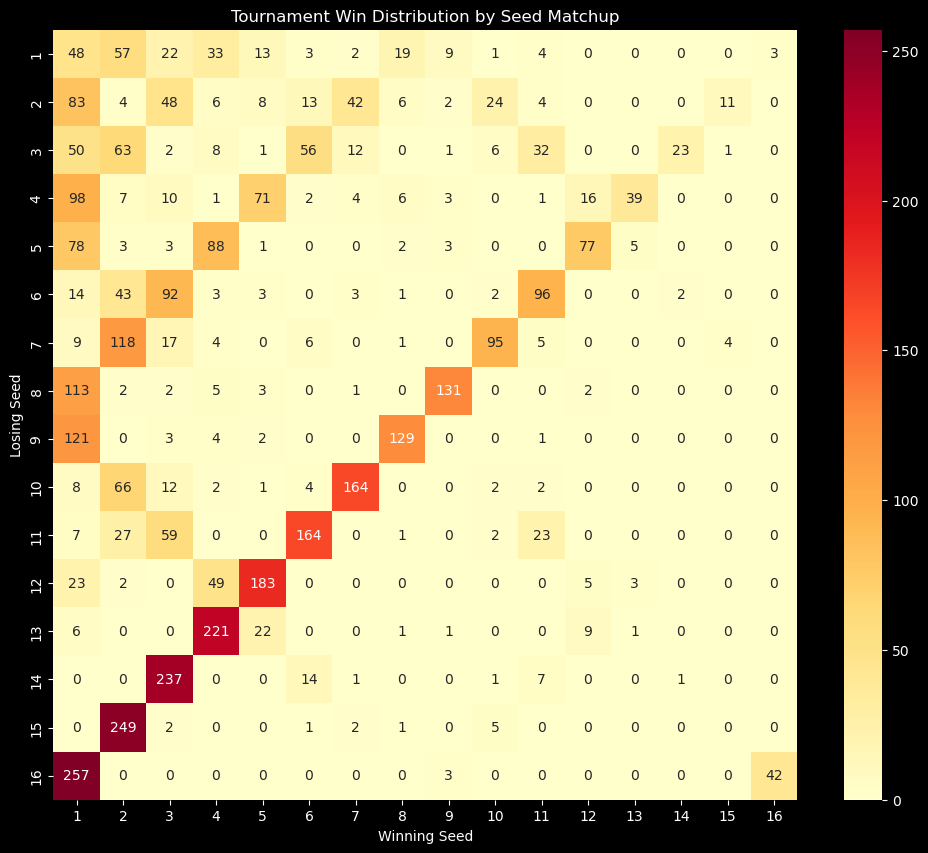

In [43]:
win_matrix = pd.crosstab(
    index=tourney_compact['LSeedValue'],
    columns=tourney_compact['WSeedValue']
).fillna(0)

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(win_matrix, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Tournament Win Distribution by Seed Matchup')
plt.xlabel('Winning Seed')
plt.ylabel('Losing Seed')
plt.show()



In [44]:
seed_performance = tourney_compact.copy()
seed_performance['Upset'] = seed_performance['WSeedValue'] > seed_performance['LSeedValue']

# Group by seed and calculate win percentage
seed_stats = seed_performance.groupby('WSeedValue').agg({
    'Season': 'count',  # Total wins by this seed
    'Upset': 'sum'      # Number of upsets by this seed
}).rename(columns={'Season': 'Wins'})

# Add visualization
fig = px.bar(seed_stats, x=seed_stats.index, y='Wins', 
             title='Tournament Wins by Seed (1985-2024)',
             labels={'WSeedValue': 'Seed', 'Wins': 'Number of Wins'},
             color='Upset', color_continuous_scale='Viridis')
fig.update_layout(xaxis_title='Seed', yaxis_title='Number of Wins')
fig.show()

In [45]:
# Create bins of seed differentials
tourney_compact['SeedDiffBin'] = pd.cut(tourney_compact['SeedDiff'], 
                                        bins=[-16, -10, -5, -1, 1, 5, 10, 16], 
                                        labels=['11-16', '6-10', '2-5', '-1-1', 
                                                '2-5', '6-10', '11-16'], ordered=False)

# Calculate upset rates by seed differential
upset_rates = tourney_compact.groupby('SeedDiffBin').size().reset_index(name='Games')
upset_rates['UpsetRate'] = tourney_compact.groupby('SeedDiffBin')['SeedDiff'].apply(
    lambda x: (x < 0).mean()).reset_index(drop=True)

# Plot
fig = px.line(upset_rates, x='SeedDiffBin', y='UpsetRate', markers=True,
              title='Probability of Upset by Seed Differential',
              labels={'SeedDiffBin': 'Seed Differential', 'UpsetRate': 'Upset Probability'})
fig.update_layout(xaxis_title='Seed Difference', yaxis_title='Upset Probability')
fig.show()

/tmp/ipykernel_64853/2809580115.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_64853/2809580115.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Model Training


In [46]:
# Filter seasons if specified
all_detailed_results = pd.concat([
    data['MRegularSeasonDetailedResults'], 
    data['WRegularSeasonDetailedResults'],
    data['MNCAATourneyDetailedResults'],
    data['WNCAATourneyDetailedResults']
]).assign(ST='All')

# Create pairs of teams for each gamr (both directions)
# For each game, create a pair of teams (winner, loser) and (loser, winner)
# with corresponding game results (1, 0) and (0, 1)

# Create pairs of teams for each game
all_detailed_results['TeamPair'] = all_detailed_results.apply(
    lambda row: tuple(sorted([row['WTeamID'], row['LTeamID']])),
    axis=1
)
# Create a DataFrame to store all game pairs with features
game_pairs = []

for _, game in all_detailed_results.iterrows():
    # Features for team1 (winner) vs team2 (loser)
    features1 = {
        'Season': game['Season'],
        'DayNum': game['DayNum'],
        'Team1': game['WTeamID'],
        'Team2': game['LTeamID'],
        'Target': 1  # Team1 won
    }
    
    # Features for team2 (loser) vs team1 (winner)
    features2 = {
        'Season': game['Season'],
        'DayNum': game['DayNum'],
        'Team1': game['LTeamID'],
        'Team2': game['WTeamID'],
        'Target': 0  # Team1 lost
    }
    
    # Add location feature if available
    if 'WLoc' in game:
        if game['WLoc'] == 'H':
            features1['Team1Home'] = 1
            features2['Team1Home'] = 0
        elif game['WLoc'] == 'A':
            features1['Team1Home'] = 0
            features2['Team1Home'] = 1
        else:  # Neutral
            features1['Team1Home'] = 0.5
            features2['Team1Home'] = 0.5
    
    # Add detailed stats if available
    if all(col in game for col in ['WFGM', 'LFGM']):
        # Team1 offensive stats when it was the winner
        features1.update({
            'Team1_FGM': game['WFGM'],
            'Team1_FGA': game['WFGA'],
            'Team1_FGM3': game['WFGM3'],
            'Team1_FGA3': game['WFGA3'],
            'Team1_FTM': game['WFTM'],
            'Team1_FTA': game['WFTA'],
            'Team1_OR': game['WOR'],
            'Team1_DR': game['WDR'],
            'Team1_Ast': game['WAst'],
            'Team1_TO': game['WTO'],
            'Team1_Stl': game['WStl'],
            'Team1_Blk': game['WBlk'],
            'Team1_PF': game['WPF'],
            
            # Team2 offensive stats when it was the loser
            'Team2_FGM': game['LFGM'],
            'Team2_FGA': game['LFGA'],
            'Team2_FGM3': game['LFGM3'],
            'Team2_FGA3': game['LFGA3'],
            'Team2_FTM': game['LFTM'],
            'Team2_FTA': game['LFTA'],
            'Team2_OR': game['LOR'],
            'Team2_DR': game['LDR'],
            'Team2_Ast': game['LAst'],
            'Team2_TO': game['LTO'],
            'Team2_Stl': game['LStl'],
            'Team2_Blk': game['LBlk'],
            'Team2_PF': game['LPF'],
        })
        
        # Team1 offensive stats when it was the loser
        features2.update({
            'Team1_FGM': game['LFGM'],
            'Team1_FGA': game['LFGA'],
            'Team1_FGM3': game['LFGM3'],
            'Team1_FGA3': game['LFGA3'],
            'Team1_FTM': game['LFTM'],
            'Team1_FTA': game['LFTA'],
            'Team1_OR': game['LOR'],
            'Team1_DR': game['LDR'],
            'Team1_Ast': game['LAst'],
            'Team1_TO': game['LTO'],
            'Team1_Stl': game['LStl'],
            'Team1_Blk': game['LBlk'],
            'Team1_PF': game['LPF'],
            
            # Team2 offensive stats when it was the winner
            'Team2_FGM': game['WFGM'],
            'Team2_FGA': game['WFGA'], 
            'Team2_FGM3': game['WFGM3'],
            'Team2_FGA3': game['WFGA3'],
            'Team2_FTM': game['WFTM'],
            'Team2_FTA': game['WFTA'],
            'Team2_OR': game['WOR'],
            'Team2_DR': game['WDR'],
            'Team2_Ast': game['WAst'],
            'Team2_TO': game['WTO'],
            'Team2_Stl': game['WStl'],
            'Team2_Blk': game['WBlk'],
            'Team2_PF': game['WPF'],
        })
    
    game_pairs.append(features1)
    game_pairs.append(features2)

# Convert to DataFrame
game_pairs_df = pd.DataFrame(game_pairs)

# Add seed information if available
if 'seeds' in locals():
    # Add Team1 seed
    game_pairs_df = pd.merge(
        game_pairs_df,
        seeds[['Season', 'TeamID', 'SeedValue']],
        how='left',
        left_on=['Season', 'Team1'],
        right_on=['Season', 'TeamID']
    )
    game_pairs_df.rename(columns={'SeedValue': 'Team1Seed'}, inplace=True)
    game_pairs_df.drop('TeamID', axis=1, inplace=True)
    
    # Add Team2 seed
    game_pairs_df = pd.merge(
        game_pairs_df,
        seeds[['Season', 'TeamID', 'SeedValue']],
        how='left',
        left_on=['Season', 'Team2'],
        right_on=['Season', 'TeamID']
    )
    game_pairs_df.rename(columns={'SeedValue': 'Team2Seed'}, inplace=True)
    game_pairs_df.drop('TeamID', axis=1, inplace=True)
    
    # Calculate seed difference
    game_pairs_df['SeedDiff'] = game_pairs_df['Team2Seed'] - game_pairs_df['Team1Seed']

# Calculate shooting percentages for both teams
game_pairs_df['Team1_FGPct'] = np.where(game_pairs_df['Team1_FGA'] > 0, 
                                      game_pairs_df['Team1_FGM'] / game_pairs_df['Team1_FGA'], 0)
game_pairs_df['Team1_FG3Pct'] = np.where(game_pairs_df['Team1_FGA3'] > 0, 
                                       game_pairs_df['Team1_FGM3'] / game_pairs_df['Team1_FGA3'], 0)
game_pairs_df['Team1_FTPct'] = np.where(game_pairs_df['Team1_FTA'] > 0, 
                                      game_pairs_df['Team1_FTM'] / game_pairs_df['Team1_FTA'], 0)

game_pairs_df['Team2_FGPct'] = np.where(game_pairs_df['Team2_FGA'] > 0, 
                                      game_pairs_df['Team2_FGM'] / game_pairs_df['Team2_FGA'], 0)
game_pairs_df['Team2_FG3Pct'] = np.where(game_pairs_df['Team2_FGA3'] > 0, 
                                       game_pairs_df['Team2_FGM3'] / game_pairs_df['Team2_FGA3'], 0)
game_pairs_df['Team2_FTPct'] = np.where(game_pairs_df['Team2_FTA'] > 0, 
                                      game_pairs_df['Team2_FTM'] / game_pairs_df['Team2_FTA'], 0)

# Calculate statistical differences between teams
game_pairs_df['ReboundDiff'] = (game_pairs_df['Team1_OR'] + game_pairs_df['Team1_DR']) - \
                             (game_pairs_df['Team2_OR'] + game_pairs_df['Team2_DR'])
game_pairs_df['AssistDiff'] = game_pairs_df['Team1_Ast'] - game_pairs_df['Team2_Ast']
game_pairs_df['TurnoverDiff'] = game_pairs_df['Team1_TO'] - game_pairs_df['Team2_TO']
game_pairs_df['StealDiff'] = game_pairs_df['Team1_Stl'] - game_pairs_df['Team2_Stl']
game_pairs_df['BlockDiff'] = game_pairs_df['Team1_Blk'] - game_pairs_df['Team2_Blk']
game_pairs_df['FoulDiff'] = game_pairs_df['Team1_PF'] - game_pairs_df['Team2_PF']

# Calculate score difference
game_pairs_df['ScoreDiff'] = game_pairs_df['Team1_FGM'] + game_pairs_df['Team1_FGM3'] + game_pairs_df['Team1_FTM'] - \
                           (game_pairs_df['Team2_FGM'] + game_pairs_df['Team2_FGM3'] + game_pairs_df['Team2_FTM'])

# Add efficiency metrics
game_pairs_df['Team1_Efficiency'] = (game_pairs_df['Team1_FGM'] + game_pairs_df['Team1_Ast']) / \
                                  (game_pairs_df['Team1_FGA'] + game_pairs_df['Team1_TO'] + 1e-6)
game_pairs_df['Team2_Efficiency'] = (game_pairs_df['Team2_FGM'] + game_pairs_df['Team2_Ast']) / \
                                  (game_pairs_df['Team2_FGA'] + game_pairs_df['Team2_TO'] + 1e-6)
game_pairs_df['EfficiencyDiff'] = game_pairs_df['Team1_Efficiency'] - game_pairs_df['Team2_Efficiency']



## Preparing Data for Modeling

### Initial Data Assessment and Cleaning

In [47]:
# 1. Remove ID columns and obvious non-predictive features
print("Original columns:", game_pairs_df.columns.tolist())
cols_to_drop = [col for col in game_pairs_df.columns if 
                col.lower().endswith(('id', 'uuid', 'timestamp', 'date'))]
print("Columns to drop based on ID/non-predictive features:", cols_to_drop)
game_pairs_df = game_pairs_df.drop(columns=cols_to_drop)

# 2. Check for near-zero variance features
print("\nChecking for near-zero variance features...")
selector = VarianceThreshold(threshold=0.01)  # Remove features with variance < 0.01
numeric_cols = game_pairs_df.select_dtypes(include=[np.number]).columns
selector.fit(game_pairs_df[numeric_cols])
low_var_cols = [col for col, var in zip(numeric_cols, selector.variances_) if var < 0.01]
print("Low variance features to drop:", low_var_cols)
game_pairs_df = game_pairs_df.drop(columns=low_var_cols)

# 3. Check for highly correlated features
# print("\nChecking for highly correlated features...")
# corr_matrix = game_pairs_df.corr().abs()
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# high_corr_features = [column for column in upper.columns 
#                      if any(upper[column] > 0.95)]
# print("Highly correlated features to drop:", high_corr_features)
# game_pairs_df = game_pairs_df.drop(columns=high_corr_features)

print("\nFinal columns after feature selection:", game_pairs_df.columns.tolist())


Original columns: ['Season', 'DayNum', 'Team1', 'Team2', 'Target', 'Team1Home', 'Team1_FGM', 'Team1_FGA', 'Team1_FGM3', 'Team1_FGA3', 'Team1_FTM', 'Team1_FTA', 'Team1_OR', 'Team1_DR', 'Team1_Ast', 'Team1_TO', 'Team1_Stl', 'Team1_Blk', 'Team1_PF', 'Team2_FGM', 'Team2_FGA', 'Team2_FGM3', 'Team2_FGA3', 'Team2_FTM', 'Team2_FTA', 'Team2_OR', 'Team2_DR', 'Team2_Ast', 'Team2_TO', 'Team2_Stl', 'Team2_Blk', 'Team2_PF', 'Team1Seed', 'Team2Seed', 'SeedDiff', 'Team1_FGPct', 'Team1_FG3Pct', 'Team1_FTPct', 'Team2_FGPct', 'Team2_FG3Pct', 'Team2_FTPct', 'ReboundDiff', 'AssistDiff', 'TurnoverDiff', 'StealDiff', 'BlockDiff', 'FoulDiff', 'ScoreDiff', 'Team1_Efficiency', 'Team2_Efficiency', 'EfficiencyDiff']
Columns to drop based on ID/non-predictive features: []

Checking for near-zero variance features...
Low variance features to drop: ['Team1_FGPct', 'Team2_FGPct']

Final columns after feature selection: ['Season', 'DayNum', 'Team1', 'Team2', 'Target', 'Team1Home', 'Team1_FGM', 'Team1_FGA', 'Team1_FGM3

In [48]:

X = game_pairs_df.drop('Target', axis=1)
y = game_pairs_df['Target']

# Display a complete row of the feature data
print("Complete feature row example:")
display(X.iloc[0:1])
print("\nCorresponding target value:")
print(y.iloc[0])

# Print the shape of the feature matrix and target vector
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2,  # 20% of data for validation
    random_state=42,
    stratify=y  # Maintain target distribution in splits
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

# Main prediction model
model = xgb.XGBRegressor(
    n_estimators=5000,         # Number of boosting rounds
    learning_rate=0.05,       # Smaller learning rate for better generalization
    max_depth=6,              # Control model complexity
    min_child_weight=3,       # Helps prevent overfitting
    subsample=0.8,            # Use 80% of data for each tree
    colsample_bytree=0.8,     # Use 80% of features for each tree
    objective='binary:logistic',  # Binary classification with probability output
    random_state=42,
    n_jobs=-1                 # Use all CPU cores
)

# Train the main model
print("\nTraining main model...")
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=20,
    verbose=True
)

# Make predictions
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

# Calculate Brier score
train_brier = ((y_train - train_preds) ** 2).mean()
val_brier = ((y_val - val_preds) ** 2).mean()

# Calculate additional metrics
train_log_loss = log_loss(y_train, np.clip(train_preds, 0.001, 0.999))
val_log_loss = log_loss(y_val, np.clip(val_preds, 0.001, 0.999))

train_accuracy = accuracy_score(y_train, np.round(train_preds))
val_accuracy = accuracy_score(y_val, np.round(val_preds))

# Store results
results = {
    'train_brier': train_brier,
    'val_brier': val_brier,
    'train_log_loss': train_log_loss,
    'val_log_loss': val_log_loss,
    'train_accuracy': train_accuracy,
    'val_accuracy': val_accuracy,
    'feature_importance': model.feature_importances_,
    'feature_names': X_train.columns.tolist()
}

# Print results
print("\nModel Evaluation Results:")
print(f"Validation Brier Score: {val_brier}")
print(f"Training Log Loss: {train_log_loss}")
print(f"Training Brier Score: {train_brier}")
print(f"Validation Log Loss: {val_log_loss}")
print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")

# Print feature importance
print("\nTop 10 Important Features:")
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)
print(feature_importance.sort_values(ascending=False).head(10))

Complete feature row example:


,Season,DayNum,Team1,Team2,Team1Home,Team1_FGM,Team1_FGA,Team1_FGM3,Team1_FGA3,Team1_FTM,...,ReboundDiff,AssistDiff,TurnoverDiff,StealDiff,BlockDiff,FoulDiff,ScoreDiff,Team1_Efficiency,Team2_Efficiency,EfficiencyDiff
0,2003,10,1104,1328,0.5,27,58,3,14,11,...,6,5,5,-2,-1,2,1,0.493827,0.422535,0.071292



Corresponding target value:
1
Feature matrix shape: (404066, 48)
Target vector shape: (404066,)

Training set shape: (323252, 48)
Validation set shape: (80814, 48)

Training main model...
[0]	validation_0-logloss:0.65887
[1]	validation_0-logloss:0.61609
[2]	validation_0-logloss:0.57863


/usr/lib/python3/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-logloss:0.55272
[4]	validation_0-logloss:0.52061
[5]	validation_0-logloss:0.48966
[6]	validation_0-logloss:0.46955
[7]	validation_0-logloss:0.44383
[8]	validation_0-logloss:0.42005
[9]	validation_0-logloss:0.39668
[10]	validation_0-logloss:0.37595
[11]	validation_0-logloss:0.35656
[12]	validation_0-logloss:0.33890
[13]	validation_0-logloss:0.32692
[14]	validation_0-logloss:0.31596
[15]	validation_0-logloss:0.30061
[16]	validation_0-logloss:0.28708
[17]	validation_0-logloss:0.27345
[18]	validation_0-logloss:0.26153
[19]	validation_0-logloss:0.25510
[20]	validation_0-logloss:0.24909
[21]	validation_0-logloss:0.23782
[22]	validation_0-logloss:0.22801
[23]	validation_0-logloss:0.21780
[24]	validation_0-logloss:0.20815
[25]	validation_0-logloss:0.19904
[26]	validation_0-logloss:0.18977
[27]	validation_0-logloss:0.18166
[28]	validation_0-logloss:0.17401
[29]	validation_0-logloss:0.16762
[30]	validation_0-logloss:0.16164
[31]	validation_0-logloss:0.15518
[32]	validation_0-log

In [50]:
submission = pd.DataFrame()
submission['ID'] = [f'{row["Season"]}_{row["Team1"]}_{row["Team2"]}' for _, row in X_val.iterrows()]
submission['Pred'] = model.predict(X_val)